In [1]:
import pandas as pd
import pickle
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression

from collections import namedtuple
import numpy as np
from sklearn_pandas import DataFrameMapper

from sklearn.externals import joblib


# Display more rows and get rid of the margins
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth',500)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Display mulitiple values from each cell
# https://stackoverflow.com/a/42476224
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Start rpy2 session
import patsy
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

rpy2.robjects.numpy2ri.activate()
print("Import Done.")

Import Done.


In [ ]:
# Install the needed rlibraries, SLOW
robjects.r('''
source("https://bioconductor.org/biocLite.R")
biocLite("sva", ask = FALSE, suppressUpdates = FALSE)
''')
robjects.r('''
source("https://bioconductor.org/biocLite.R")
biocLite("BiocParallel", ask = FALSE, suppressUpdates = FALSE)
''')

/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: A new version of Bioconductor is available after installing the most recent
  version of R; see http://bioconductor.org/install

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: BioC_mirror: https://bioconductor.org

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.3.1 (2016-06-21).

  res = super(Function, self).__call__(*new_args, **new_kwarg

KeyboardInterrupt: 

/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Content type 'application/x-gzip'
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning:  length 197610 bytes (192 KB)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: =
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: downloaded 192 KB


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/

In [2]:
# Load the combat function

robjects.r('library(sva)')
robjects.r('library(BiocParallel)')
robjects.r('''modifiedComBat <- function (dat, batch, mod = NULL, par.prior = FALSE, prior.plots = FALSE, 
           mean.only = FALSE, ref.batch = NULL, BPPARAM = bpparam("SerialParam"), dat2 = NULL, batch2 = NULL, mod2 = NULL) 
{
  if (mean.only == TRUE) {
    message("Using the 'mean only' version of ComBat")
  }
  if (length(dim(batch)) > 1) {
    stop("This version of ComBat only allows one batch variable")
  }
  if (is.null(batch2)) {
    batch <- as.factor(batch)
  }
  else {
    n1 <- length(batch)
    allbatch <- as.factor(c(batch, batch2))
    batch <- allbatch[1:n1]
    batch2 <- allbatch[(n1 + 1):length(allbatch)]
  }
  batchmod <- model.matrix(~-1 + batch)
  if (!is.null(dat2)) batchmod2 <- model.matrix(~-1 + batch2)
  if (!is.null(ref.batch)) {
    if (!(ref.batch %in% levels(batch))) {
      stop("reference level ref.batch is not one of the levels of the batch variable")
    }
    cat("Using batch =", ref.batch, "as a reference batch (this batch won't change)\n")
    ref <- which(levels(as.factor(batch)) == ref.batch)
    batchmod[, ref] <- 1
    if (!is.null(dat2)) {
      ref2 <- which(levels(as.factor(batch2)) == ref.batch)
      batchmod2[, ref2] <- 1
    }
  }
  else {
    ref <- NULL
  }
  message("Found", nlevels(batch), "batches")
  n.batch <- nlevels(batch)
  batches <- list()
  for (i in 1:n.batch) {
    batches[[i]] <- which(batch == levels(batch)[i])
  }
  if (!is.null(dat2)) {
    batches2 <- list()
    for (i in 1:n.batch) {
      batches2[[i]] <- which(batch2 == levels(batch)[i])
    }
  }
  n.batches <- sapply(batches, length)
  if (any(n.batches == 1)) {
    mean.only = TRUE
    message("Note: one batch has only one sample, setting mean.only=TRUE")
  }
  n.array <- sum(n.batches)
  design <- cbind(batchmod, mod)
  check <- apply(design, 2, function(x) all(x == 1))
  if (!is.null(ref)) {
    check[ref] <- FALSE
  }
  design <- as.matrix(design[, !check])
  if (!is.null(dat2)) {
    n.batches2 <- sapply(batches2, length)
    n.array2 <- sum(n.batches2)
    design2 <- cbind(batchmod2, mod2)
    check2 <- apply(design2, 2, function(x) all(x == 1))
    if (!is.null(ref)) {
      check2[ref] <- FALSE
    } 
    design2 <- as.matrix(design2[, !check2])
  }
  message("Adjusting for", ncol(design) - ncol(batchmod), "covariate(s) or covariate level(s)")
  if (qr(design)$rank < ncol(design)) {
    if (ncol(design) == (n.batch + 1)) {
      stop("The covariate is confounded with batch! Remove the covariate and rerun ComBat")
    }
    if (ncol(design) > (n.batch + 1)) {
      if ((qr(design[, -c(1:n.batch)])$rank < ncol(design[, 
                                                          -c(1:n.batch)]))) {
        stop("The covariates are confounded! Please remove one or more of the covariates so the design is not confounded")
      }
      else {
        stop("At least one covariate is confounded with batch! Please remove confounded covariates and rerun ComBat")
      }
    }
  }
  NAs <- any(is.na(dat))
  if (NAs) {
    message(c("Found", sum(is.na(dat)), "Missing Data Values"), 
            sep = " ")
  }
  cat("Standardizing Data across genes\n")
  
  if (!NAs) {
    B.hat <- solve(crossprod(design), tcrossprod(t(design), 
                                                 as.matrix(dat)))
  }
    else {
      B.hat <- apply(dat, 1, Beta.NA, design)
    }
  if (!is.null(ref.batch)) {
    grand.mean <- t(B.hat[ref, ])
  }
    else {
      grand.mean <- crossprod(n.batches/n.array, B.hat[1:n.batch, 
                                                       ])
    }
  if (!NAs) {
    if (!is.null(ref.batch)) {
      ref.dat <- dat[, batches[[ref]]]
      var.pooled <- ((ref.dat - t(design[batches[[ref]], 
                                         ] %*% B.hat))^2) %*% rep(1/n.batches[ref], n.batches[ref])
    }
    else {
      var.pooled <- ((dat - t(design %*% B.hat))^2) %*% 
        rep(1/n.array, n.array)
    }
  }
    else {
      if (!is.null(ref.batch)) {
        ref.dat <- dat[, batches[[ref]]]
        var.pooled <- rowVars(ref.dat - t(design[batches[[ref]], 
                                                 ] %*% B.hat), na.rm = TRUE)
      }
      else {
        var.pooled <- rowVars(dat - t(design %*% B.hat), 
                              na.rm = TRUE)
      }
    }
  stand.mean <- t(grand.mean) %*% t(rep(1, n.array))
  if (!is.null(dat2)) stand.mean2 <- t(grand.mean) %*% t(rep(1, n.array2))
  if (!is.null(design)) {
    tmp <- design
    tmp[, c(1:n.batch)] <- 0
    stand.mean <- stand.mean + t(tmp %*% B.hat)
    if (!is.null(dat2)) {
      tmp2 <- design2
      tmp2[, c(1:n.batch)] <- 0
      stand.mean2 <- stand.mean2 + t(tmp2 %*% B.hat)
    }
  }
  s.data <- (dat - stand.mean)/(sqrt(var.pooled) %*% t(rep(1, 
                                                           n.array)))
  if (!is.null(dat2)) {
    s.data2 <- (dat2 - stand.mean2)/(sqrt(var.pooled) %*% t(rep(1, 
                                                             n.array2)))
  }
  message("Fitting L/S model and finding priors")
  batch.design <- design[, 1:n.batch]
  if (!is.null(dat2)) batch.design2 <- design2[, 1:n.batch]
  if (!NAs) {
    gamma.hat <- solve(crossprod(batch.design), tcrossprod(t(batch.design), 
                                                           as.matrix(s.data)))
  }
    else {
      gamma.hat <- apply(s.data, 1, Beta.NA, batch.design)
    }
  delta.hat <- NULL
  for (i in batches) {
    if (mean.only == TRUE) {
      delta.hat <- rbind(delta.hat, rep(1, nrow(s.data)))
    }
    else {
      delta.hat <- rbind(delta.hat, rowVars(s.data[, i], 
                                            na.rm = TRUE))
    }
  }
  gamma.bar <- rowMeans(gamma.hat)
  t2 <- rowVars(gamma.hat)
  a.prior <- apply(delta.hat, 1, sva:::aprior)
  b.prior <- apply(delta.hat, 1, sva:::bprior)
  if (prior.plots && par.prior) {
    par(mfrow = c(2, 2))
    tmp <- density(gamma.hat[1, ])
    plot(tmp, type = "l", main = expression(paste("Density Plot of First Batch ", 
                                                  hat(gamma))))
    xx <- seq(min(tmp$x), max(tmp$x), length = 100)
    lines(xx, dnorm(xx, gamma.bar[1], sqrt(t2[1])), col = 2)
    qqnorm(gamma.hat[1, ], main = expression(paste("Normal Q-Q Plot of First Batch ", 
                                                   hat(gamma))))
    qqline(gamma.hat[1, ], col = 2)
    tmp <- density(delta.hat[1, ])
    xx <- seq(min(tmp$x), max(tmp$x), length = 100)
    tmp1 <- list(x = xx, y = sva:::dinvgamma(xx, a.prior[1], b.prior[1]))
    plot(tmp, typ = "l", ylim = c(0, max(tmp$y, tmp1$y)), 
         main = expression(paste("Density Plot of First Batch ", 
                                 hat(delta))))
    lines(tmp1, col = 2)
    invgam <- 1/qgamma(1 - ppoints(ncol(delta.hat)), a.prior[1], 
                       b.prior[1])
    qqplot(invgam, delta.hat[1, ], main = expression(paste("Inverse Gamma Q-Q Plot of First Batch ", 
                                                           hat(delta))), ylab = "Sample Quantiles", xlab = "Theoretical Quantiles")
    lines(c(0, max(invgam)), c(0, max(invgam)), col = 2)
  }
  gamma.star <- delta.star <- matrix(NA, nrow = n.batch, ncol = nrow(s.data))
  if (par.prior) {
    message("Finding parametric adjustments")
    results <- BiocParallel:::bplapply(1:n.batch, function(i) {
      if (mean.only) {
        gamma.star <- postmean(gamma.hat[i, ], gamma.bar[i], 
                               1, 1, t2[i])
        delta.star <- rep(1, nrow(s.data))
      }
      else {
        temp <- sva:::it.sol(s.data[, batches[[i]]], gamma.hat[i, 
                                                               ], delta.hat[i, ], gamma.bar[i], t2[i], a.prior[i], 
                             b.prior[i])
        gamma.star <- temp[1, ]
        delta.star <- temp[2, ]
      }
      list(gamma.star = gamma.star, delta.star = delta.star)
    }, BPPARAM = BPPARAM)
    for (i in 1:n.batch) {
      gamma.star[i, ] <- results[[i]]$gamma.star
      delta.star[i, ] <- results[[i]]$delta.star
    }
  }
    else {
      message("Finding nonparametric adjustments")
      results <- BiocParallel:::bplapply(1:n.batch, function(i) {
        if (mean.only) {
          delta.hat[i, ] = 1
        }
        temp <- sva:::int.eprior(as.matrix(s.data[, batches[[i]]]), 
                           gamma.hat[i, ], delta.hat[i, ])
        list(gamma.star = temp[1, ], delta.star = temp[2, 
                                                       ])
      }, BPPARAM = BPPARAM)
      for (i in 1:n.batch) {
        gamma.star[i, ] <- results[[i]]$gamma.star
        delta.star[i, ] <- results[[i]]$delta.star
      }
    }
  if (!is.null(ref.batch)) {
    gamma.star[ref, ] <- 0
    delta.star[ref, ] <- 1
  }
  message("Adjusting the Data\n")
  bayesdata <- s.data
  j <- 1
  for (i in batches) {
    bayesdata[, i] <- (bayesdata[, i] - t(batch.design[i, 
                                                       ] %*% gamma.star))/(sqrt(delta.star[j, ]) %*% t(rep(1, 
                                                                                                           n.batches[j])))
    j <- j + 1
  }
  bayesdata <- (bayesdata * (sqrt(var.pooled) %*% t(rep(1, 
                                                        n.array)))) + stand.mean
  if (!is.null(ref.batch)) {
    bayesdata[, batches[[ref]]] <- dat[, batches[[ref]]]
  }
  if (!is.null(dat2)) {
    bayesdata2 <- s.data2
    j <- 1
    for (i in batches2) {
      bayesdata2[, i] <- (bayesdata2[, i] - t(batch.design2[i, 
                                                         ] %*% gamma.star))/(sqrt(delta.star[j, ]) %*% t(rep(1, 
                                                                                                             n.batches2[j])))
      j <- j + 1
    }
    bayesdata2 <- (bayesdata2 * (sqrt(var.pooled) %*% t(rep(1, 
                                                          n.array2)))) + stand.mean2
    if (!is.null(ref.batch)) {
      bayesdata2[, batches2[[ref]]] <- dat2[, batches2[[ref]]]
    }
    return(list(corrected = bayesdata, alpha = grand.mean, beta.hat = B.hat, gamma.star = gamma.star, delta.star = delta.star,
                corrected2 = bayesdata2))
  }
  return(list(corrected = bayesdata, alpha = grand.mean, beta.hat = B.hat, gamma.star = gamma.star, delta.star = delta.star))
}
''')
combat = robjects.r('modifiedComBat')

/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: mgcv

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: nlme

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: This is mgcv 1.8-23. For overview type 'help("mgcv-package")'.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: genefilter

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Creating a generic function 

array(['sva', 'genefilter', 'mgcv', 'nlme', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'],
      dtype='<U10')

array(['BiocParallel', 'sva', 'genefilter', 'mgcv', 'nlme', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'],
      dtype='<U12')

<SignatureTranslatedFunction - Python:0x2b258c22eb88 / R:0x2b25b327af40>

# Simulate some data

In [3]:
def run_combat(feats, meta, model="~1",
              feats_test=None, meta_test=None, model_test=None, par_prior=False):
    model_matrix = patsy.dmatrix(model, meta)
    fmat = np.array(feats).T
    rbatch = robjects.IntVector(pd.Categorical(meta.site).codes)
    
    if (meta_test is not None) and (feats_test is not None):
        if model_test is None:
            model_test = model
        model_matrix_test = patsy.dmatrix(model_test, meta_test)
        fmat_test = np.array(feats_test).T
        rbatch_test = robjects.IntVector(pd.Categorical(meta_test.site).codes)
        combat_result = combat(dat=fmat, batch=rbatch, mod=model_matrix,
                               dat2=fmat_test, batch2=rbatch_test, mod2=model_matrix_test, par_prior=par_prior)
    else:
        combat_result = combat(dat = fmat, batch = rbatch, mod = model_matrix)
    combat_result = [np.array(cr) for cr in combat_result]
    return combat_result

In [7]:
n_samples = 800
n_cols = 200
n_class = 2
train_test_ratio = 1

In [8]:
# Generate Random Data

#n_class=2, train_test_ratio =1
random_data = []
for i in range(0, 100):
    simY_r = np.random.randint(0,n_class, n_samples)
    simX_r = np.random.normal(size = (n_samples,n_cols))
    simY_e = np.random.randint(0, n_class, n_samples//train_test_ratio)
    simX_e = np.random.normal(size = (n_samples//train_test_ratio, n_cols))
    arr = [simY_r, simX_r, simY_e, simX_e, n_class, train_test_ratio]
    random_data.append(arr)

n_class = 2
train_test_ratio = 5
for i in range(0, 100):
    simY_r = np.random.randint(0,n_class, n_samples)
    simX_r = np.random.normal(size = (n_samples,n_cols))
    simY_e = np.random.randint(0, n_class, n_samples//train_test_ratio)
    simX_e = np.random.normal(size = (n_samples//train_test_ratio, n_cols))
    arr = [simY_r, simX_r, simY_e, simX_e, n_class, train_test_ratio]
    random_data.append(arr)

n_class = 10
train_test_ratio = 1
for i in range(0, 100):
    simY_r = np.random.randint(0,n_class, n_samples)
    simX_r = np.random.normal(size = (n_samples,n_cols))
    simY_e = np.random.randint(0, n_class, n_samples//train_test_ratio)
    simX_e = np.random.normal(size = (n_samples//train_test_ratio, n_cols))
    arr = [simY_r, simX_r, simY_e, simX_e, n_class, train_test_ratio]
    random_data.append(arr)

n_class = 10
train_test_ratio = 5
for i in range(0, 100):
    simY_r = np.random.randint(0,n_class, n_samples)
    simX_r = np.random.normal(size = (n_samples,n_cols))
    simY_e = np.random.randint(0, n_class, n_samples//train_test_ratio)
    simX_e = np.random.normal(size = (n_samples//train_test_ratio, n_cols))
    arr = [simY_r, simX_r, simY_e, simX_e, n_class, train_test_ratio]
    random_data.append(arr)

In [11]:
def run_sim(random_data, sim_num):
    simY_r = random_data[sim_num][0]
    simX_r = random_data[sim_num][1]
    simY_e = random_data[sim_num][2]
    simX_e = random_data[sim_num][3]
    
    n_class = random_data[sim_num][4]
    train_test_ratio = random_data[sim_num][5]
    
    # Make the columns strings so the dataframe mapper doesn't choke
    simX_r = pd.DataFrame(data=simX_r, columns=np.arange(n_cols).astype(str))
    metric_cols = simX_r.columns
    simX_r['site'] = simY_r.astype(str)
    simX_e = pd.DataFrame(data=simX_e, columns=metric_cols)
    simX_e['site'] = simY_e.astype(str)
    
    cb_meta_cols = ['site']
    simX = pd.concat((simX_r, simX_e)).reset_index(drop=True)
    simX_r_cb1 = simX_r.copy(deep=True)
    simX_e_cb1 = simX_e.copy(deep=True)
    simX_r_cb2 = simX_r.copy(deep=True)
    simX_e_cb2 = simX_e.copy(deep=True)
    simX_r_cb3 = simX_r.copy(deep=True)
    simX_e_cb3 = simX_e.copy(deep=True)
    
    # combat application 1: whole dataset
    combat_res = run_combat(simX.loc[:, metric_cols], simX.loc[:, ['site']],
                        model='~1')
    
    simX_r_cb2.loc[:, metric_cols] = combat_res[0].T[:len(simX_r)]
    simX_e_cb2.loc[:, metric_cols] = combat_res[0].T[len(simX_r):]
    
    # combat application 2: train learn test apply
    combat_res = run_combat(simX_r.loc[:, metric_cols], simX_r.loc[:, ['site']],
                        feats_test= simX_e.loc[:, metric_cols],
                        meta_test= simX_e.loc[:, ['site']],
                        model='~1')
    
    simX_r_cb2.loc[:, metric_cols] = combat_res[0].T
    simX_e_cb2.loc[:, metric_cols] = combat_res[5].T
    
    # combat application 3: train learn test apply
    combat_res_r = run_combat(simX_r.loc[:, metric_cols], simX_r.loc[:, ['site']],
                        model='~1')
    combat_res_e = run_combat(simX_e.loc[:, metric_cols], simX_e.loc[:, ['site']],
                        model='~1')
    
    simX_r_cb3.loc[:, metric_cols] = combat_res_r[0].T
    simX_e_cb3.loc[:, metric_cols] = combat_res_e[0].T
    
    mapper = DataFrameMapper([([str(nv)],preprocessing.StandardScaler()) for nv in metric_cols])
    sim_clf = Pipeline([('preprocessing', mapper),
                    ('clf', LogisticRegression(multi_class='multinomial', solver='saga', max_iter = 100000,
                                               penalty='l2',
                                               C=1,
                                               fit_intercept=True,
                                               n_jobs=1))])
    
    output = [sim_num, n_class, train_test_ratio]
    
    sim_clf.fit(simX_r, simY_r)
    output.append(sim_clf.score(simX_r, simY_r))
    output.append(sim_clf.score(simX_e, simY_e))
    
    sim_clf.fit(simX_r_cb1, simY_r)
    output.append(sim_clf.score(simX_r_cb1, simY_r))
    output.append(sim_clf.score(simX_e_cb1, simY_e))
    
    sim_clf.fit(simX_r_cb2, simY_r)
    output.append(sim_clf.score(simX_r_cb2, simY_r))
    output.append(sim_clf.score(simX_e_cb2, simY_e))
    
    sim_clf.fit(simX_r_cb3, simY_r)
    output.append(sim_clf.score(simX_r_cb3, simY_r))
    output.append(sim_clf.score(simX_e_cb3, simY_e))
    
    return output

# Run Simulations
We need to parallelize this to run ~ 100 times each for train_test_ratio of 1, train_test_ratio of 5, n_class= 2, n_class = 10

In [12]:
cb_var_res = joblib.Parallel(n_jobs=20, verbose=50)(joblib.delayed(run_sim)(random_data, n) for n in range(400))

/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__cal

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   53.1s


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done   2 tasks      | elapsed:  1.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done   3 tasks      | elapsed:  1.1min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done   4 tasks      | elapsed:  1.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=20)]: Done   6 tasks      | elapsed:  1.6min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done   7 tasks      | elapsed:  1.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done   8 tasks      | elapsed:  2.1min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done   9 tasks      | elapsed:  2.3min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  2.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:  2.7min
[Parallel(n_jobs=20)]: Done  12 tasks      | elapsed:  2.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  13 tasks      | elapsed:  3.1min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  14 tasks      | elapsed:  3.3min
Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  15 tasks      | elapsed:  3.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  16 tasks      | elapsed:  3.8min
[Parallel(n_jobs=20)]: Done  17 tasks      | elapsed:  3.8min
[Parallel(n_jobs=20)]: Done  18 tasks      | elapsed:  3.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  19 tasks      | elapsed:  4.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  20 tasks      | elapsed:  5.0min
Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:  5.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  22 tasks      | elapsed:  5.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  23 tasks      | elapsed:  5.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes
Standardizing Data across genes


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  24 tasks      | elapsed:  5.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  25 tasks      | elapsed:  6.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  26 tasks      | elapsed:  6.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  27 tasks      | elapsed:  6.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  28 tasks      | elapsed:  6.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  29 tasks      | elapsed:  6.6min
[Parallel(n_jobs=20)]: Done  30 tasks      | elapsed:  6.6min
Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  31 tasks      | elapsed:  6.6min
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:  6.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  33 tasks      | elapsed:  6.7min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  34 tasks      | elapsed:  6.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  35 tasks      | elapsed:  6.9min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  36 tasks      | elapsed:  7.1min
Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  37 tasks      | elapsed:  7.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  38 tasks      | elapsed:  7.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  39 tasks      | elapsed:  7.3min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  40 tasks      | elapsed:  7.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  41 tasks      | elapsed:  7.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  42 tasks      | elapsed:  7.4min
Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)



Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  43 tasks      | elapsed:  7.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  44 tasks      | elapsed:  7.5min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed:  7.6min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes
Standardizing Data across genes


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  46 tasks      | elapsed:  7.7min
[Parallel(n_jobs=20)]: Done  47 tasks      | elapsed:  7.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  48 tasks      | elapsed:  7.9min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  49 tasks      | elapsed:  7.9min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  50 tasks      | elapsed:  8.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  51 tasks      | elapsed:  8.0min
Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:  8.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  53 tasks      | elapsed:  8.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  54 tasks      | elapsed:  8.1min
[Parallel(n_jobs=20)]: Done  55 tasks      | elapsed:  8.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  56 tasks      | elapsed:  8.3min
Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  57 tasks      | elapsed:  8.5min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed:  8.6min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  59 tasks      | elapsed:  8.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  60 tasks      | elapsed:  8.7min
[Parallel(n_jobs=20)]: Done  61 tasks      | elapsed:  8.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  62 tasks      | elapsed:  8.9min
[Parallel(n_jobs=20)]: Done  63 tasks      | elapsed:  8.9min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  64 tasks      | elapsed:  9.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  65 tasks      | elapsed:  9.0min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  66 tasks      | elapsed:  9.0min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  67 tasks      | elapsed:  9.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  68 tasks      | elapsed:  9.2min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  69 tasks      | elapsed:  9.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  70 tasks      | elapsed:  9.3min
[Parallel(n_jobs=20)]: Done  71 tasks      | elapsed:  9.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes
Standardizing Data across genes




/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  72 tasks      | elapsed:  9.6min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  73 tasks      | elapsed:  9.7min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  74 tasks      | elapsed:  9.7min
Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  75 tasks      | elapsed:  9.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  76 tasks      | elapsed:  9.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  77 tasks      | elapsed:  9.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  78 tasks      | elapsed:  9.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  79 tasks      | elapsed:  9.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  80 tasks      | elapsed: 10.0min
Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  81 tasks      | elapsed: 10.0min
[Parallel(n_jobs=20)]: Done  82 tasks      | elapsed: 10.0min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  83 tasks      | elapsed: 10.2min
Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  84 tasks      | elapsed: 10.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  85 tasks      | elapsed: 10.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  86 tasks      | elapsed: 10.4min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  87 tasks      | elapsed: 10.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed: 10.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  89 tasks      | elapsed: 10.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  90 tasks      | elapsed: 10.6min
Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kw

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  91 tasks      | elapsed: 11.0min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  92 tasks      | elapsed: 11.1min
Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  93 tasks      | elapsed: 11.1min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  94 tasks      | elapsed: 11.2min
Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  95 tasks      | elapsed: 11.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  96 tasks      | elapsed: 11.2min
Standardizing Data across genes

[Parallel(n_jobs=20)]: Done  97 tasks      | elapsed: 11.3min
[Parallel(n_jobs=20)]: Done  98 tasks      | elapsed: 11.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done  99 tasks      | elapsed: 11.3min
[Parallel(n_jobs=20)]: Done 100 tasks      | elapsed: 11.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 101 tasks      | elapsed: 11.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 102 tasks      | elapsed: 11.3min
[Parallel(n_jobs=20)]: Done 103 tasks      | elapsed: 11.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 104 tasks      | elapsed: 11.4min
Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 105 tasks      | elapsed: 11.5min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 106 tasks      | elapsed: 11.6min
Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 107 tasks      | elapsed: 11.6min
Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed: 11.6min
[Parallel(n_jobs=20)]: Done 109 tasks      | elapsed: 11.7min
[Parallel(n_jobs=20)]: Done 110 tasks      | elapsed: 11.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 111 tasks      | elapsed: 11.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__cal

Standardizing Data across genes

Standardizing Data across genes


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 112 tasks      | elapsed: 12.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 113 tasks      | elapsed: 12.1min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 114 tasks      | elapsed: 12.3min
[Parallel(n_jobs=20)]: Done 115 tasks      | elapsed: 12.3min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 116 tasks      | elapsed: 12.3min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 117 tasks      | elapsed: 12.3min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 118 tasks      | elapsed: 12.4min
Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 119 tasks      | elapsed: 12.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes
Standardizing Data across genes




/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 120 tasks      | elapsed: 12.5min
Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 121 tasks      | elapsed: 12.5min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed: 12.6min
[Parallel(n_jobs=20)]: Done 123 tasks      | elapsed: 12.6min
[Parallel(n_jobs=20)]: Done 124 tasks      | elapsed: 12.6min
[Parallel(n_jobs=20)]: Done 125 tasks      | elapsed: 12.6min
Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 126 tasks      | elapsed: 12.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 127 tasks      | elapsed: 12.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 128 tasks      | elapsed: 12.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 129 tasks      | elapsed: 12.8min
Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 130 tasks      | elapsed: 12.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 131 tasks      | elapsed: 13.0min
Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 132 tasks      | elapsed: 13.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 133 tasks      | elapsed: 13.2min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 134 tasks      | elapsed: 13.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 135 tasks      | elapsed: 13.3min
[Parallel(n_jobs=20)]: Done 136 tasks      | elapsed: 13.3min
Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 137 tasks      | elapsed: 13.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 138 tasks      | elapsed: 13.4min
Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 139 tasks      | elapsed: 13.4min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 140 tasks      | elapsed: 13.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 141 tasks      | elapsed: 13.7min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 142 tasks      | elapsed: 13.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 143 tasks      | elapsed: 13.8min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 144 tasks      | elapsed: 13.8min
[Parallel(n_jobs=20)]: Done 145 tasks      | elapsed: 13.8min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 146 tasks      | elapsed: 13.9min
Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 147 tasks      | elapsed: 13.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 148 tasks      | elapsed: 14.0min
Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 149 tasks      | elapsed: 14.0min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 150 tasks      | elapsed: 14.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 151 tasks      | elapsed: 14.0min
Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 152 tasks      | elapsed: 14.1min
[Parallel(n_jobs=20)]: Done 153 tasks      | elapsed: 14.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 154 tasks      | elapsed: 14.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 155 tasks      | elapsed: 14.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 156 tasks      | elapsed: 14.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 157 tasks      | elapsed: 14.5min
[Parallel(n_jobs=20)]: Done 158 tasks      | elapsed: 14.5min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 159 tasks      | elapsed: 14.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed: 14.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 161 tasks      | elapsed: 14.8min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 162 tasks      | elapsed: 14.9min
Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 163 tasks      | elapsed: 14.9min
Standardizing Data across genes

Standardizing Data across genes
Standardizing Data across genes


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 164 tasks      | elapsed: 15.0min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 165 tasks      | elapsed: 15.1min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 166 tasks      | elapsed: 15.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 167 tasks      | elapsed: 15.1min
Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 168 tasks      | elapsed: 15.2min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 169 tasks      | elapsed: 15.2min
[Parallel(n_jobs=20)]: Done 170 tasks      | elapsed: 15.2min
[Parallel(n_jobs=20)]: Done 171 tasks      | elapsed: 15.2min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 172 tasks      | elapsed: 15.3min
Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 173 tasks      | elapsed: 15.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 174 tasks      | elapsed: 15.4min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 175 tasks      | elapsed: 15.5min
Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 176 tasks      | elapsed: 15.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 177 tasks      | elapsed: 15.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 178 tasks      | elapsed: 15.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 179 tasks      | elapsed: 15.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 180 tasks      | elapsed: 15.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 181 tasks      | elapsed: 15.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 182 tasks      | elapsed: 15.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 183 tasks      | elapsed: 15.9min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 184 tasks      | elapsed: 16.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 185 tasks      | elapsed: 16.1min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 186 tasks      | elapsed: 16.1min
[Parallel(n_jobs=20)]: Done 187 tasks      | elapsed: 16.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 188 tasks      | elapsed: 16.2min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found2batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 189 tasks      | elapsed: 16.3min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 190 tasks      | elapsed: 16.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 191 tasks      | elapsed: 16.5min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 192 tasks      | elapsed: 16.5min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 193 tasks      | elapsed: 16.6min
Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 194 tasks      | elapsed: 16.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 195 tasks      | elapsed: 16.7min
[Parallel(n_jobs=20)]: Done 196 tasks      | elapsed: 16.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 197 tasks      | elapsed: 16.7min
[Parallel(n_jobs=20)]: Done 198 tasks      | elapsed: 16.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 199 tasks      | elapsed: 16.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 200 tasks      | elapsed: 16.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__ca

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 201 tasks      | elapsed: 18.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 202 tasks      | elapsed: 18.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 203 tasks      | elapsed: 18.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 204 tasks      | elapsed: 19.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 205 tasks      | elapsed: 20.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 206 tasks      | elapsed: 22.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages

[Parallel(n_jobs=20)]: Done 207 tasks      | elapsed: 56.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 208 tasks      | elapsed: 57.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 209 tasks      | elapsed: 60.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 210 tasks      | elapsed: 81.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 211 tasks      | elapsed: 82.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 212 tasks      | elapsed: 88.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: A

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 213 tasks      | elapsed: 88.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 214 tasks      | elapsed: 88.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 215 tasks      | elapsed: 88.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 216 tasks      | elapsed: 88.8min
[Parallel(n_jobs=20)]: Done 217 tasks      | elapsed: 88.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 218 tasks      | elapsed: 88.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 219 tasks      | elapsed: 89.0min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 220 tasks      | elapsed: 89.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 221 tasks      | elapsed: 89.1min
Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Funct

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 222 tasks      | elapsed: 89.2min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 223 tasks      | elapsed: 89.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 224 tasks      | elapsed: 89.3min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 225 tasks      | elapsed: 89.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 226 tasks      | elapsed: 89.6min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 227 tasks      | elapsed: 89.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 228 tasks      | elapsed: 90.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 229 tasks      | elapsed: 90.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 230 tasks      | elapsed: 90.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 231 tasks      | elapsed: 90.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 232 tasks      | elapsed: 91.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 233 tasks      | elapsed: 92.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 234 tasks      | elapsed: 94.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 235 tasks      | elapsed: 97.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 236 tasks      | elapsed: 98.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 237 tasks      | elapsed: 114.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages

[Parallel(n_jobs=20)]: Done 238 tasks      | elapsed: 126.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 239 tasks      | elapsed: 127.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 240 tasks      | elapsed: 128.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 241 tasks      | elapsed: 128.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 242 tasks      | elapsed: 129.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 243 tasks      | elapsed: 131.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 244 tasks      | elapsed: 132.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 245 tasks      | elapsed: 132.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 246 tasks      | elapsed: 133.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 247 tasks      | elapsed: 135.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed: 136.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 249 tasks      | elapsed: 155.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 250 tasks      | elapsed: 161.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 251 tasks      | elapsed: 161.4min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: A

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 252 tasks      | elapsed: 161.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 253 tasks      | elapsed: 161.7min
[Parallel(n_jobs=20)]: Done 254 tasks      | elapsed: 161.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 255 tasks      | elapsed: 161.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 256 tasks      | elapsed: 162.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 257 tasks      | elapsed: 162.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 258 tasks      | elapsed: 162.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 259 tasks      | elapsed: 162.6min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 260 tasks      | elapsed: 162.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 261 tasks      | elapsed: 163.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 262 tasks      | elapsed: 163.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 263 tasks      | elapsed: 163.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 264 tasks      | elapsed: 163.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 265 tasks      | elapsed: 163.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 266 tasks      | elapsed: 163.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 267 tasks      | elapsed: 164.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 268 tasks      | elapsed: 164.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 269 tasks      | elapsed: 164.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 270 tasks      | elapsed: 164.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 271 tasks      | elapsed: 167.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 272 tasks      | elapsed: 167.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 273 tasks      | elapsed: 169.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 274 tasks      | elapsed: 170.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 275 tasks      | elapsed: 171.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 276 tasks      | elapsed: 172.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 277 tasks      | elapsed: 173.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 278 tasks      | elapsed: 176.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 279 tasks      | elapsed: 177.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed: 187.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 281 tasks      | elapsed: 188.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 282 tasks      | elapsed: 196.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages

[Parallel(n_jobs=20)]: Done 283 tasks      | elapsed: 201.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 284 tasks      | elapsed: 203.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 285 tasks      | elapsed: 205.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages

[Parallel(n_jobs=20)]: Done 286 tasks      | elapsed: 228.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 287 tasks      | elapsed: 230.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 288 tasks      | elapsed: 231.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 289 tasks      | elapsed: 233.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 290 tasks      | elapsed: 234.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 291 tasks      | elapsed: 234.6min
[Parallel(n_jobs=20)]: Done 292 tasks      | elapsed: 234.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: F

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 293 tasks      | elapsed: 234.8min
Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 294 tasks      | elapsed: 234.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 295 tasks      | elapsed: 235.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 296 tasks      | elapsed: 236.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 297 tasks      | elapsed: 236.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 298 tasks      | elapsed: 236.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 299 tasks      | elapsed: 237.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 300 tasks      | elapsed: 238.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 301 tasks      | elapsed: 239.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 302 tasks      | elapsed: 240.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 303 tasks      | elapsed: 241.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 304 tasks      | elapsed: 241.4min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 305 tasks      | elapsed: 241.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 306 tasks      | elapsed: 245.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 307 tasks      | elapsed: 247.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 308 tasks      | elapsed: 250.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 309 tasks      | elapsed: 260.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 310 tasks      | elapsed: 261.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 311 tasks      | elapsed: 262.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 312 tasks      | elapsed: 269.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 313 tasks      | elapsed: 272.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 314 tasks      | elapsed: 272.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 315 tasks      | elapsed: 273.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 316 tasks      | elapsed: 275.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 317 tasks      | elapsed: 276.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 318 tasks      | elapsed: 276.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 319 tasks      | elapsed: 277.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages

[Parallel(n_jobs=20)]: Done 320 tasks      | elapsed: 303.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 321 tasks      | elapsed: 307.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 322 tasks      | elapsed: 307.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 323 tasks      | elapsed: 307.5min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 324 tasks      | elapsed: 308.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 325 tasks      | elapsed: 308.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 326 tasks      | elapsed: 309.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 327 tasks      | elapsed: 309.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 328 tasks      | elapsed: 311.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 329 tasks      | elapsed: 313.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 330 tasks      | elapsed: 314.1min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 331 tasks      | elapsed: 314.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 332 tasks      | elapsed: 315.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 333 tasks      | elapsed: 315.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 334 tasks      | elapsed: 316.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 335 tasks      | elapsed: 317.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 336 tasks      | elapsed: 317.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 337 tasks      | elapsed: 318.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 338 tasks      | elapsed: 319.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 339 tasks      | elapsed: 319.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 340 tasks      | elapsed: 322.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 341 tasks      | elapsed: 322.3min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 342 tasks      | elapsed: 322.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 343 tasks      | elapsed: 323.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 344 tasks      | elapsed: 324.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 345 tasks      | elapsed: 333.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 346 tasks      | elapsed: 341.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 347 tasks      | elapsed: 342.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages

[Parallel(n_jobs=20)]: Done 348 tasks      | elapsed: 347.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 349 tasks      | elapsed: 348.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 350 tasks      | elapsed: 348.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 351 tasks      | elapsed: 348.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 352 tasks      | elapsed: 349.5min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 353 tasks      | elapsed: 355.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages

[Parallel(n_jobs=20)]: Done 354 tasks      | elapsed: 376.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 355 tasks      | elapsed: 379.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 356 tasks      | elapsed: 379.4min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 357 tasks      | elapsed: 379.7min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 358 tasks      | elapsed: 380.1min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[Parallel(n_jobs=20)]: Done 359 tasks      | elapsed: 380.2min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 360 tasks      | elapsed: 380.7min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 361 tasks      | elapsed: 380.9min
Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 370 out of 400 | elapsed: 393.1min remaining: 31.9min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes

[Parallel(n_jobs=20)]: Done 379 out of 400 | elapsed: 411.2min remaining: 22.8min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Found10batches

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting for0covariate(s) or covariate level(s)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fitting L/S model and finding priors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Finding nonparametric adjustments

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: Adjusting the Data


  res = super(Function, self).__call__(*new_args, **new_kwargs)


Standardizing Data across genes

Standardizing Data across genes

Standardizing Data across genes



/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages

[Parallel(n_jobs=20)]: Done 388 out of 400 | elapsed: 452.5min remaining: 14.0min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages

[Parallel(n_jobs=20)]: Done 397 out of 400 | elapsed: 473.4min remaining:  3.6min


/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[Parallel(n_jobs=20)]: Done 400 out of 400 | elapsed: 486.6min finished


In [13]:
np.savetxt("simulation_output.csv", cb_var_res, delimiter=",")

# Load output and see what the results are

In [1]:
import pandas as pd

In [2]:
res = pd.read_csv('simulation_output.csv', names=['number_of_simulation', 'n_class', 'train_test_ratio',
                                                  'score_raw_r', 'score_raw_e', 'score_combatCorrection1_r',
                                                  'score_combatCorrection1_e', 'score_combatCorrection2_r',
                                                  'score_combatCorrection2_e', 'score_combatCorrection3_r',
                                                  'score_combatCorrection3_e'])

In [3]:
res.groupby(['n_class', 'train_test_ratio']).head()

,number_of_simulation,n_class,train_test_ratio,score_raw_r,score_raw_e,score_combatCorrection1_r,score_combatCorrection1_e,score_combatCorrection2_r,score_combatCorrection2_e,score_combatCorrection3_r,score_combatCorrection3_e
0,0.0,2.0,1.0,0.68875,0.48125,0.68875,0.48125,0.62750,0.45125,0.62750,0.48375
1,1.0,2.0,1.0,0.73625,0.49875,0.73625,0.49875,0.64500,0.43375,0.64500,0.50250
2,2.0,2.0,1.0,0.70875,0.49000,0.70875,0.49000,0.63875,0.42875,0.63875,0.48750
3,3.0,2.0,1.0,0.74625,0.50625,0.74625,0.50625,0.64750,0.42500,0.64750,0.49625
4,4.0,2.0,1.0,0.71625,0.48750,0.71625,0.48750,0.65250,0.43000,0.65250,0.48500
100,100.0,2.0,5.0,0.72000,0.51250,0.72000,0.51250,0.67250,0.42500,0.67250,0.50000
101,101.0,2.0,5.0,0.71875,0.48750,0.71875,0.48750,0.65125,0.43125,0.65125,0.48750
102,102.0,2.0,5.0,0.75000,0.46875,0.75000,0.46875,0.66000,0.41250,0.66000,0.46875
103,103.0,2.0,5.0,0.71625,0.54375,0.71625,0.54375,0.64500,0.46250,0.64500,0.50625
104,104.0,2.0,5.0,0.71875,0.43750,0.72000,0.43750,0.67000,0.38750,0.67000,0.46875


In [6]:
res['dif_combatCorrection1_e'] = res.score_combatCorrection1_e - res.score_raw_e
res['dif_combatCorrection2_e'] = res.score_combatCorrection2_e - res.score_raw_e
res['dif_combatCorrection3_e'] = res.score_combatCorrection3_e - res.score_raw_e


In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

/data/nielsond/python/envs/abcd_mine/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


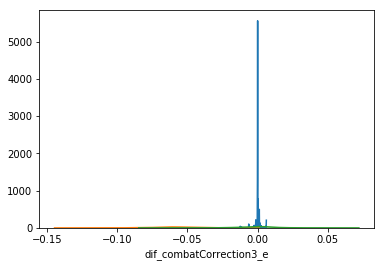

In [8]:
sns.distplot(res['dif_combatCorrection1_e'])
sns.distplot(res['dif_combatCorrection2_e'])
sns.distplot(res['dif_combatCorrection3_e'])